In [27]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import xgboost as xgb
from PIL import Image, ImageOps
from PIL import ImageOps
from sklearn.metrics import ndcg_score
import shap

## Creating file 'nba_dpoy_ml_data'

In [28]:
df_player_adv = pd.read_csv("data/Advanced.csv", encoding='utf-8')
df_player_as = pd.read_csv("data/Player Award Shares.csv", encoding='utf-8')
df_player_pg = pd.read_csv("data/Player Per Game.csv", encoding='utf-8')
df_player_tv = pd.read_csv("data/End of Season Teams (Voting).csv", encoding='utf-8')
df_player_pp = pd.read_csv("data/Per 100 Poss.csv", encoding='utf-8')

columns_to_merge_pg = [
    'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 
    'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 
    'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 
    'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 
    'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 
    'tov_per_game', 'pf_per_game', 'pts_per_game'
]
df_player_adv = df_player_adv.merge(
    df_player_pg[['season', 'player'] + columns_to_merge_pg],
    on=['season', 'player'],
    how='left'
)

df_award_encoded = pd.get_dummies(df_player_as['award'], prefix='award')
df_award_encoded = df_award_encoded.mul(df_player_as['share'], axis=0)
df_transformed = df_player_as.join(df_award_encoded)
df_transformed = df_transformed.drop(columns=['award', 'share'])
df_transformed.columns = [col + '_share' if col.startswith('award_') else col for col in df_transformed.columns]
columns_to_drop_as = ['age', 'tm', 'first', 'pts_won', 'pts_max', 'winner', 'seas_id', 'player_id']
df_transformed = df_transformed.drop(columns=columns_to_drop_as)
df_summed_as = df_transformed.groupby(['season', 'player']).sum().reset_index()
columns_to_merge_as = [
    'award_aba mvp_share', 'award_aba roy_share',
    'award_clutch_poy_share', 'award_dpoy_share',
    'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 'award_smoy_share'
    
]
df_player_adv = df_player_adv.merge(
    df_summed_as[['season', 'player'] + columns_to_merge_as],
    on=['season', 'player'],
    how='left'
)

df_player_tv['number_tm'] = df_player_tv['number_tm'].replace('1T', '1st')
df_player_tv['type_number_tm'] = df_player_tv['type'].astype(str) + '_' + df_player_tv['number_tm'].astype(str)
df_pivot = df_player_tv.pivot(index=['season', 'player'], columns='type_number_tm', values='share').reset_index()

df_pivot.columns.name = None
df_pivot.rename(columns=lambda x: f"{x}_share" if x not in ['season', 'player'] else x, inplace=True)

df_player_adv = df_player_adv.merge(
    df_pivot,
    on=['season', 'player'],
    how='left'
)

df_player_sum = df_pivot.groupby(['season', 'player']).sum().reset_index()

df_player_adv = df_player_adv.merge(
    df_player_sum[['season', 'player']],
    on=['season', 'player'],
    how='left'
)

df_player_adv = df_player_adv.drop_duplicates(subset=['season', 'player'], keep='first')
df_player_adv = df_player_adv.drop(columns=['birth_year'])
df_player_adv.columns = df_player_adv.columns.str.replace('type_number_tm', 'team')

df_player_adv['award_dpoy_share'] = df_player_adv['award_dpoy_share'].fillna(0)
df_player_adv['season'] = df_player_adv['season'].fillna(0)

def assign_won_dpoy(df_player_adv):
    df_player_adv['won_dpoy'] = 0
    idx = df_player_adv.groupby('season')['award_dpoy_share'].idxmax()
    # Ensure that 'won_dpoy' is set to 0 if 'award_dpoy_share' is 0
    for i in idx:
        if df_player_adv.loc[i, 'award_dpoy_share'] > 0:
            df_player_adv.loc[i, 'won_dpoy'] = 1
    return df_player_adv

df_player_adv = assign_won_dpoy(df_player_adv)

df_player_adv['All-Defense_1st'] = df_player_adv['All-Defense_1st_share'].apply(lambda x: 1 if x > 0 else 0)
df_player_adv['All-Defense_2nd'] = df_player_adv['All-Defense_2nd_share'].apply(lambda x: 1 if x > 0 else 0)
df_player_adv['All-Defense'] = df_player_adv.apply(lambda row: 1 if row['All-Defense_1st'] == 1 or row['All-Defense_2nd'] == 1 else 0, axis=1)

df_player_adv['All-NBA_1st'] = df_player_adv['All-NBA_1st_share'].apply(lambda x: 1 if x > 0 else 0)
df_player_adv['All-NBA_2nd'] = df_player_adv['All-NBA_2nd_share'].apply(lambda x: 1 if x > 0 else 0)
df_player_adv['All-NBA'] = df_player_adv.apply(lambda row: 1 if row['All-NBA_1st'] == 1 or row['All-NBA_2nd'] == 1 else 0, axis=1)

df_team_avg = df_player_pp.groupby(['season', 'tm'])[['o_rtg', 'd_rtg']].mean().reset_index()

df_team_avg.rename(columns={'o_rtg': 'team_o_rtg', 'd_rtg': 'team_d_rtg'}, inplace=True)

df_player_adv = df_player_adv.merge(df_team_avg, on=['season', 'tm'], how='left')

df_player_pp_subset = df_player_pp[['season', 'player', 'o_rtg', 'd_rtg']]

df_player_adv = df_player_adv.merge(df_player_pp_subset, on=['season', 'player'], how='left')

df_player_adv['season_player'] = df_player_adv['season'].astype(str) + '_' + df_player_adv['player']

df_player_adv = df_player_adv.drop_duplicates(subset=['season_player'])

df_player_adv.to_csv("nba_dpoy_ml_data.csv", index=False, encoding='utf-8')

### Anaylze the DPOY data

In [37]:
df_data = pd.read_csv("nba_dpoy_ml_data.csv", encoding='utf-8')
print(list(df_data))

['seas_id', 'season', 'player_id', 'player', 'pos', 'age', 'experience', 'lg', 'tm', 'g', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game', 'award_aba mvp_share', 'award_aba roy_share', 'award_clutch_poy_share', 'award_dpoy_share', 'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 'award_smoy_share', 'All-Defense_1st_share', 'All-Defense_2nd_share', 'All-Defense_ORV_share', 'All-NBA_1st_share', 'All-NBA_2T_share', 'All-NBA_2nd_share', 'All-NBA_3T

In [38]:
df_data

,seas_id,season,player_id,player,pos,age,experience,lg,tm,g,...,All-Defense_2nd,All-Defense,All-NBA_1st,All-NBA_2nd,All-NBA,team_o_rtg,team_d_rtg,o_rtg,d_rtg,season_player
0,31136,2024,5025,A.J. Green,SG,24.0,2,NBA,MIL,56,...,0,0,0,0,0,111.650000,115.809524,122.0,120.0,2024_A.J. Green
1,31137,2024,5026,A.J. Lawson,SG,23.0,2,NBA,DAL,42,...,0,0,0,0,0,114.681818,115.454545,105.0,117.0,2024_A.J. Lawson
2,31138,2024,5027,AJ Griffin,SF,20.0,2,NBA,ATL,20,...,0,0,0,0,0,114.210526,119.631579,77.0,124.0,2024_AJ Griffin
3,31139,2024,4219,Aaron Gordon,PF,28.0,10,NBA,DEN,73,...,0,0,0,0,0,116.647059,112.882353,125.0,114.0,2024_Aaron Gordon
4,31140,2024,4582,Aaron Holiday,PG,27.0,6,NBA,HOU,78,...,0,0,0,0,0,117.882353,112.941176,117.0,116.0,2024_Aaron Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25782,200,1947,157,Walt Miller,F,31.0,1,BAA,PIT,12,...,0,0,0,0,0,NaN,NaN,NaN,NaN,1947_Walt Miller
25783,201,1947,158,Warren Fenley,F,24.0,1,BAA,BOS,33,...,0,0,0,0,0,NaN,NaN,NaN,NaN,1947_Warren Fenley
25784,202,1947,159,Wilbert Kautz,G-F,31.0,1,BAA,CHS,50,...,0,0,0,0,0,NaN,NaN,NaN,NaN,1947_Wilbert Kautz
25785,203,1947,160,Woody Grimshaw,G,27.0,1,BAA,PRO,21,...,0,0,0,0,0,NaN,NaN,NaN,NaN,1947_Woody Grimshaw


In [39]:
data_columns = ['age', 'pos','g', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game', 'award_aba mvp_share', 'award_aba roy_share', 'award_clutch_poy_share', 'award_dpoy_share', 'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 'award_smoy_share', 'All-Defense_1st_share', 'All-Defense_2nd_share', 'All-Defense_ORV_share', 'All-NBA_1st_share', 'All-NBA_2T_share', 'All-NBA_2nd_share', 'All-NBA_3T_share', 'All-NBA_3rd_share', 'All-NBA_ORV_share', 'All-Rookie_1st_share', 'All-Rookie_2nd_share', 'All-Rookie_ORV_share', 'won_dpoy', 'All-Defense_1st', 'All-Defense_2nd', 'All-Defense', 'All-NBA_1st', 'All-NBA_2nd', 'All-NBA', 'team_o_rtg', 'team_d_rtg', 'o_rtg', 'd_rtg']

#df_data = df_data.dropna(subset=data_columns)
data = df_data[data_columns].copy()

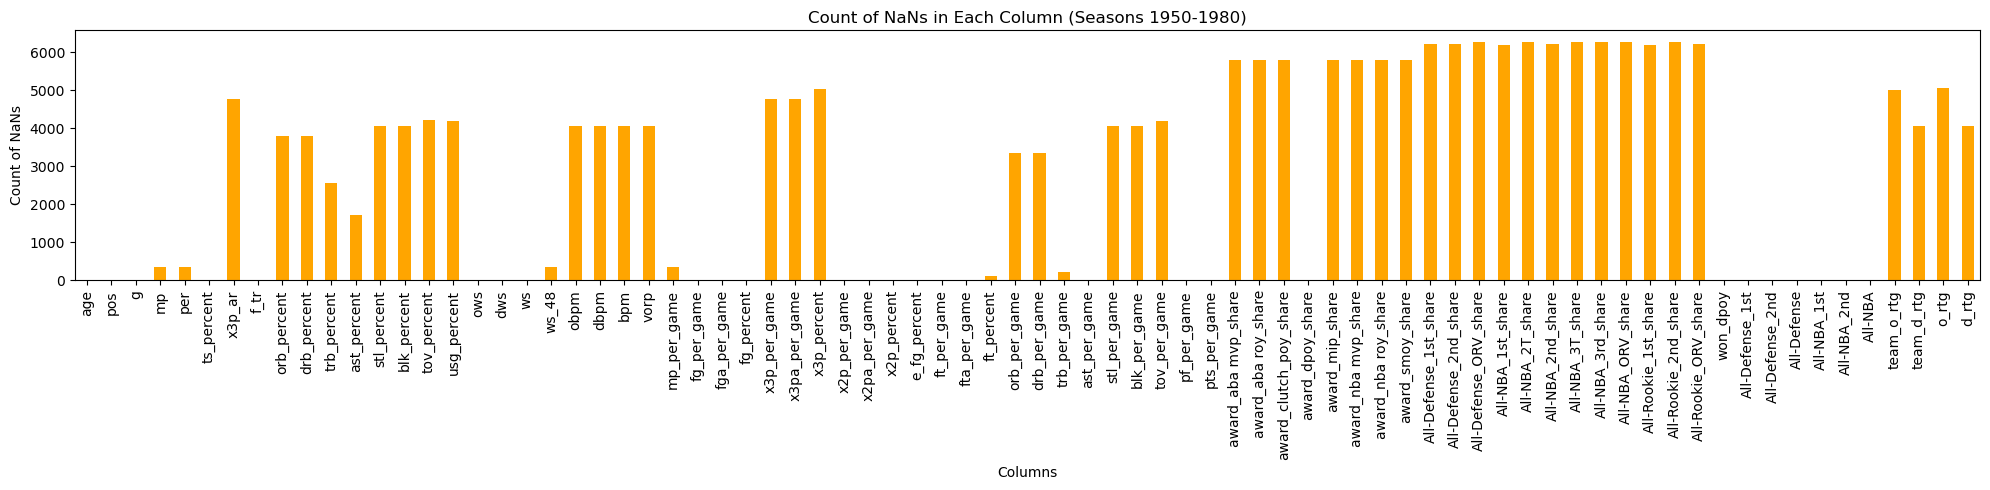

In [40]:
filtered_df = df_data[(df_data['season'] >= 1950) & (df_data['season'] <= 1980)]

nan_counts_filtered = filtered_df[data_columns].isna().sum()

plt.figure(figsize=(20, 5))
nan_counts_filtered.plot(kind='bar', color='orange')
plt.title('Count of NaNs in Each Column (Seasons 1950-1980)')
plt.xlabel('Columns')
plt.ylabel('Count of NaNs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

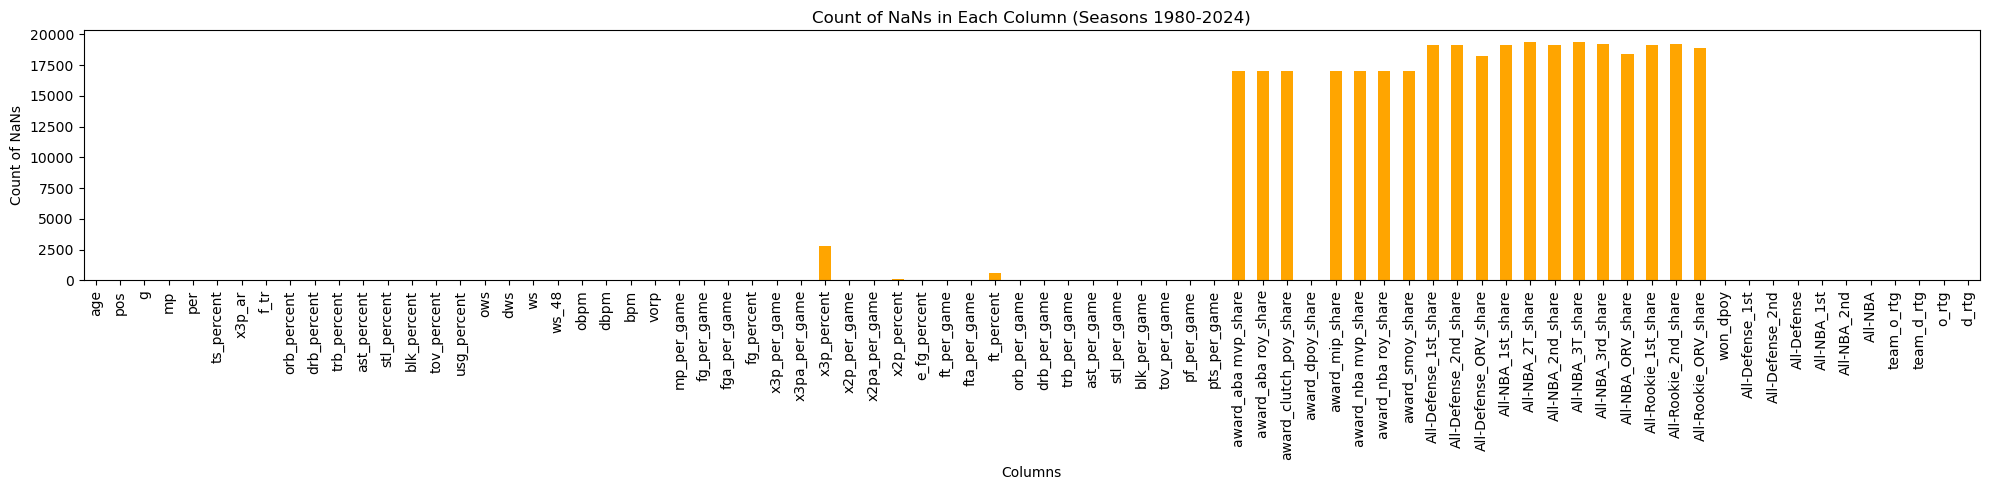

In [41]:
filtered_df = df_data[(df_data['season'] >= 1980) & (df_data['season'] <= 2024)]

nan_counts_filtered = filtered_df[data_columns].isna().sum()

plt.figure(figsize=(20, 5))
nan_counts_filtered.plot(kind='bar', color='orange')
plt.title('Count of NaNs in Each Column (Seasons 1980-2024)')
plt.xlabel('Columns')
plt.ylabel('Count of NaNs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Converting raw data to league ranks for further analysis

In [42]:
exclude_columns = ['season_player', 'seas_id', 'season', 'player_id', 'player', 'pos', 'lg', 'tm', 'won_dpoy', 'All-Defense_1st', 'All-Defense_2nd', 'All-Defense', 'All-NBA_1st', 'All-NBA_2nd', 'All-NBA']

reverse_rank_columns = ['d_rtg','team_d_rtg']

for col in df_data.columns:
    if col not in exclude_columns:
        if col in reverse_rank_columns:
            df_data[col] = df_data.groupby('season')[col].rank(method='min', ascending=True)
        else:
            df_data[col] = df_data.groupby('season')[col].rank(method='min', ascending=False)
          
df_ranks = df_data

df_ranks.to_csv("nba_dpoy_ml_data_ranks.csv", index=False, encoding='utf-8')

In [43]:
df_ranks = pd.read_csv("nba_dpoy_ml_data_ranks.csv", encoding='utf-8')

In [44]:
specific_seasons = [1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978]

summed_df = df_data.groupby('season', as_index=False)['won_dpoy'].sum()

unique_seasons_df = df_data.drop_duplicates(subset=['season'])

filtered_df = summed_df[summed_df['season'].isin(specific_seasons)]

filtered_df[['season', 'won_dpoy']]

,season,won_dpoy
31,1978,0
32,1979,0
33,1980,0
34,1981,0
35,1982,0
36,1983,1
37,1984,1
38,1985,1
39,1986,1


- dpoy originated in 1983.

In [45]:
df_ranks = pd.read_csv("nba_dpoy_ml_data_ranks.csv", encoding='utf-8')

df_ranks.drop(df_ranks[df_ranks['season'] < 1983].index, inplace = True)

champions_df = df_ranks[df_ranks['won_dpoy'] == 1]
unique_ranks = champions_df['dws'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['dws'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of {rank}: {percentage:.0f}%")

The percentage of Rank 1.0: 29%
The percentage of Rank 2.0: 24%
The percentage of Rank 7.0: 12%
The percentage of Rank 8.0: 10%
The percentage of Rank 11.0: 5%
The percentage of Rank 4.0: 5%
The percentage of Rank 6.0: 5%
The percentage of Rank 9.0: 2%
The percentage of Rank 5.0: 2%
The percentage of Rank 3.0: 2%
The percentage of Rank 79.0: 2%
The percentage of Rank 27.0: 2%


In [46]:
27+23+2+5+2+5+9+9

82

In [47]:
df_ranks = pd.read_csv("nba_dpoy_ml_data_ranks.csv", encoding='utf-8')

df_ranks.drop(df_ranks[df_ranks['season'] < 1983].index, inplace = True)

champions_df = df_ranks[df_ranks['won_dpoy'] == 1]
unique_ranks = champions_df['All-Defense'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['All-Defense'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of {rank}: {percentage:.0f}%")

The percentage of Rank 1: 100%


In [48]:
df_ranks = pd.read_csv("nba_dpoy_ml_data_ranks.csv", encoding='utf-8')

df_ranks.drop(df_ranks[df_ranks['season'] < 1983].index, inplace = True)

champions_df = df_ranks[df_ranks['won_dpoy'] == 1]
unique_ranks = champions_df['All-NBA'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['All-NBA'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of {rank}: {percentage:.0f}%")

The percentage of Rank 0: 50%
The percentage of Rank 1: 50%


In [49]:
df_ranks = pd.read_csv("nba_dpoy_ml_data_ranks.csv", encoding='utf-8')

df_ranks.drop(df_ranks[df_ranks['season'] < 1983].index, inplace = True)

champions_df = df_ranks[df_ranks['won_dpoy'] == 1]
unique_ranks = champions_df['All-Defense_1st'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['All-Defense_1st'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of {rank}: {percentage:.0f}%")

The percentage of Rank 1: 90%
The percentage of Rank 0: 10%


In [50]:
df_ranks = pd.read_csv("nba_dpoy_ml_data_ranks.csv", encoding='utf-8')

df_ranks.drop(df_ranks[df_ranks['season'] < 1983].index, inplace = True)

champions_df = df_ranks[df_ranks['won_dpoy'] == 1]
unique_ranks = champions_df['All-NBA_1st'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['All-NBA_1st'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of {rank}: {percentage:.0f}%")

The percentage of Rank 0: 69%
The percentage of Rank 1: 31%


In [51]:
df_ranks = pd.read_csv("nba_dpoy_ml_data_ranks.csv", encoding='utf-8')

df_ranks.drop(df_ranks[df_ranks['season'] < 1983].index, inplace = True)

champions_df = df_ranks[df_ranks['won_dpoy'] == 1]
unique_ranks = champions_df['d_rtg'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['d_rtg'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of {rank}: {percentage:.0f}%")

The percentage of Rank 3.0: 14%
The percentage of Rank 2.0: 12%
The percentage of Rank 4.0: 10%
The percentage of Rank 6.0: 7%
The percentage of Rank 1.0: 7%
The percentage of Rank 5.0: 5%
The percentage of Rank 12.0: 5%
The percentage of Rank 21.0: 5%
The percentage of Rank 29.0: 5%
The percentage of Rank 61.0: 2%
The percentage of Rank 9.0: 2%
The percentage of Rank 35.0: 2%
The percentage of Rank 7.0: 2%
The percentage of Rank 11.0: 2%
The percentage of Rank 14.0: 2%
The percentage of Rank 10.0: 2%
The percentage of Rank 28.0: 2%
The percentage of Rank 8.0: 2%
The percentage of Rank 121.0: 2%
The percentage of Rank 32.0: 2%
The percentage of Rank 44.0: 2%
The percentage of Rank 86.0: 2%


In [52]:
print(list(df_ranks))

['seas_id', 'season', 'player_id', 'player', 'pos', 'age', 'experience', 'lg', 'tm', 'g', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game', 'award_aba mvp_share', 'award_aba roy_share', 'award_clutch_poy_share', 'award_dpoy_share', 'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 'award_smoy_share', 'All-Defense_1st_share', 'All-Defense_2nd_share', 'All-Defense_ORV_share', 'All-NBA_1st_share', 'All-NBA_2T_share', 'All-NBA_2nd_share', 'All-NBA_3T

In [53]:
36+14+12+2+7

71

In [54]:
filtered_df = df_data[(df_data['won_dpoy'] == 1) & (df_data['All-Defense_1st'] == 0)]

result_df = filtered_df[['season', 'player']]

result_df

,season,player
6101,2013,Marc Gasol
6716,2012,Tyson Chandler
13955,1995,Dikembe Mutombo
17219,1986,Alvin Robertson


### Analysis Notes:
- 82% of the time dpoy is top 8 in dws.
- 100% of the time dpoy make all-defense.
- 52% of the time dpoy make all-nba.
- 91% of the time dpoy is 1st team all defense.
- d_rtg and team_d_rtg did not show strong league rank success amongst players.
- 13 Marc Gasol, 12 Tyson Chandler, 95 Dikembe Mutumbo, and 86 Alvin Robertson were the only players in NBA history to win dpoy, NOT on 1st team all defense.

### Machine Learning Process:
##### Model Logistic Classifier (on 'won_dpoy' target feature) v. Model Random-Forest Classifier (on 'award_dpoy_share' target feature)

- I want to see which model is better for mainly predicing the one target scenario. A classification model, trained on mix (synethic/real) data to caputre a real/synethic prediction or a regression model used to predict a specific value that measures that players worthiness for winning the dpoy.

- 1st: Define features, analyze features using importances, correlation plots, and multi-correlation checks.
- 2nd: Test the model performance on predicing dpoys that already exists.
- 3rd: Once a good present model is established, we will run the model on the non-exisiting DPOY winner seasons (to find the player that should've won back then, before award creation.)
- 4th: Analyze the models results on non-real dpoys and research personally what the "peoples" choice was to see how well the model is predicting.
- 5th: Show model decision making.

### Logistic Regression Classifier Model:

In [55]:
df = pd.read_csv("nba_dpoy_ml_data.csv", encoding='utf-8')
df.fillna(0, inplace=True)
print(list(df))

['seas_id', 'season', 'player_id', 'player', 'pos', 'age', 'experience', 'lg', 'tm', 'g', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game', 'award_aba mvp_share', 'award_aba roy_share', 'award_clutch_poy_share', 'award_dpoy_share', 'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 'award_smoy_share', 'All-Defense_1st_share', 'All-Defense_2nd_share', 'All-Defense_ORV_share', 'All-NBA_1st_share', 'All-NBA_2T_share', 'All-NBA_2nd_share', 'All-NBA_3T

#### Feature Selection

In [56]:
data_columns = ['age', 'experience','g', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent',
                'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mp_per_game', 'fg_per_game', 'fga_per_game', 
                'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game',
                'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game',
                'award_aba mvp_share', 'award_aba roy_share', 'award_clutch_poy_share', 'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 
                'award_smoy_share', 'All-Defense_1st_share', 'All-Defense_2nd_share', 'All-Defense_ORV_share', 'All-NBA_1st_share', 'All-NBA_2T_share', 'All-NBA_2nd_share', 
                'All-NBA_3T_share', 'All-NBA_3rd_share', 'All-NBA_ORV_share', 'All-Rookie_1st_share', 'All-Rookie_2nd_share', 'All-Rookie_ORV_share', 'All-Defense_1st',
                'All-Defense_2nd', 'All-Defense', 'All-NBA_1st', 'All-NBA_2nd', 'All-NBA', 'team_o_rtg', 'team_d_rtg', 'o_rtg', 'd_rtg']
                
df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

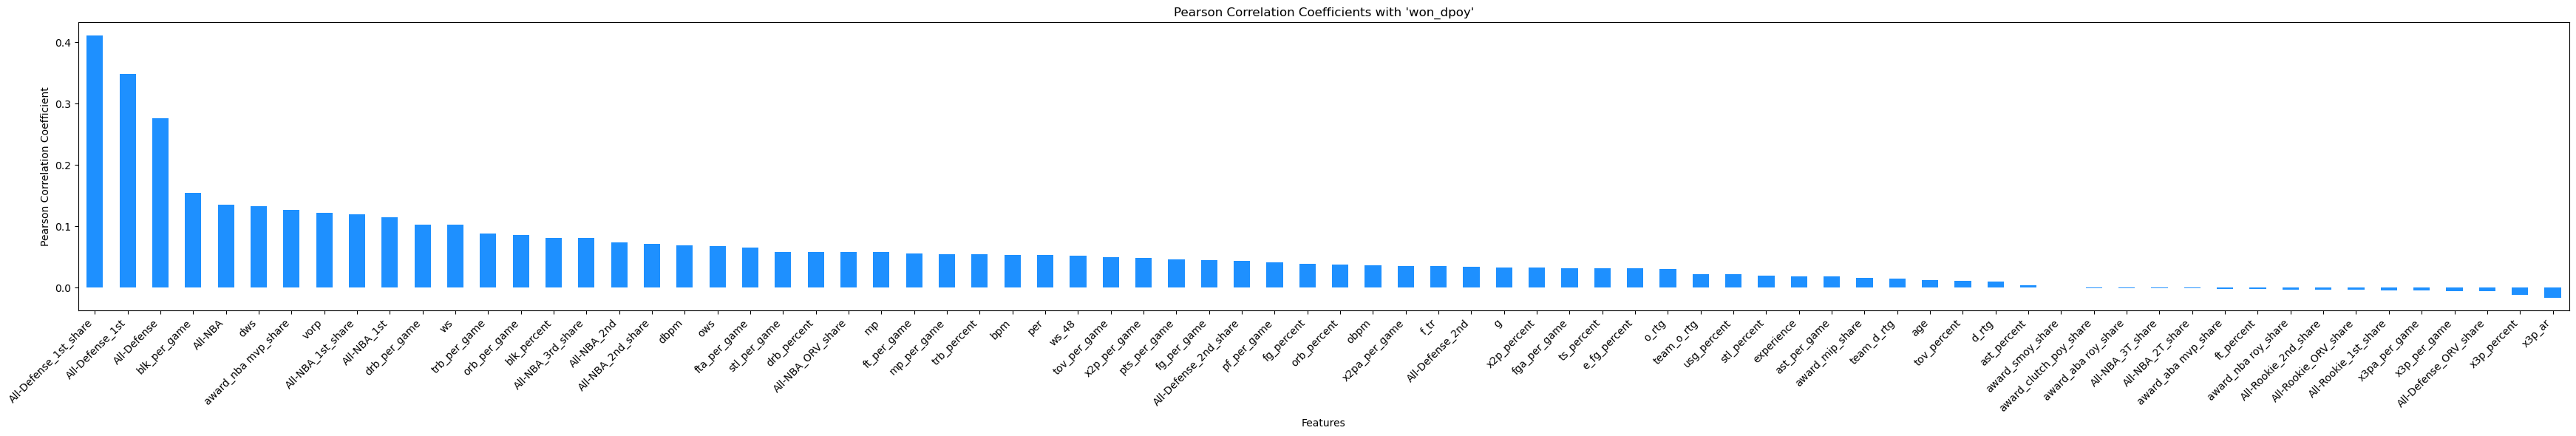

In [57]:

correlations = df[data_columns].corrwith(df['won_dpoy'])


correlations = correlations.sort_values(ascending=False)


plt.figure(figsize=(35, 6))
correlations.plot(kind='bar', color='dodgerblue')
plt.title("Pearson Correlation Coefficients with 'won_dpoy'")
plt.xlabel("Features")
plt.ylabel("Pearson Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [58]:
features = ['All-Defense_1st_share', 'blk_per_game', 'dws',
           'vorp', 'drb_per_game', 'ws','trb_per_game', 'blk_percent', 
           'per', 'mp', 'tov_per_game', 'age', 'team_d_rtg', 'stl_per_game', 'dbpm', 'g', 'ft_percent', 'bpm', 'pf_per_game',
           ]


target_variable = 'won_dpoy'

num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 19


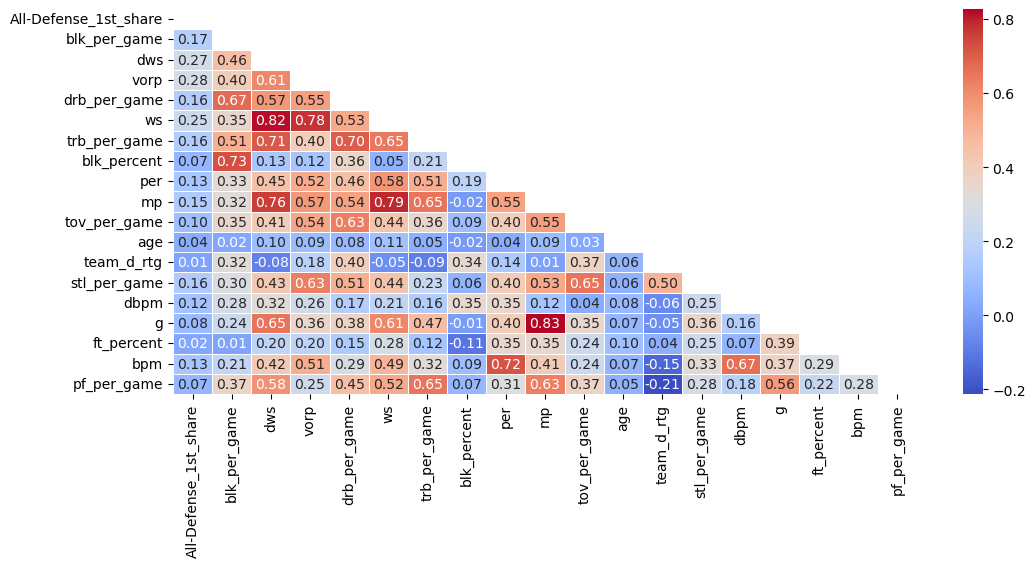

In [59]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

### Predicting current DPOY's

In [60]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

train = df[df["season"].between(1982, 2019)].copy()
test = df[df["season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

smote = SMOTE(random_state=42)
train_features_resampled, train_target_resampled = smote.fit_resample(train[features], train["won_dpoy"])

lr = LogisticRegression(random_state=5, max_iter=100)
lr.fit(train_features_resampled, train_target_resampled)

test_predictions = lr.predict(test[features])
test_probabilities = lr.predict_proba(test[features])[:, 1]

predictions_df = pd.DataFrame(test_predictions, columns=["pred_won_dpoy"], index=test.index)
probabilities_df = pd.DataFrame(test_probabilities, columns=["pred_dpoy_prob"], index=test.index)

frame = pd.concat([test[["season", "player", 'won_dpoy']], predictions_df, probabilities_df], axis=1)
frame.sort_values(["season", "pred_dpoy_prob"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(10))
print("-----------------------------------------------------------------------------\n")

# Hit-Rate Calculation
hit_rate = accuracy_score(test["won_dpoy"], test_predictions)

print("Hit-Rate: ")
print("=============================================================================\n")
print("Hit-Rate: ", hit_rate)
print("-----------------------------------------------------------------------------\n")

Results:

     season                   player  won_dpoy  pred_won_dpoy  pred_dpoy_prob
483    2024              Rudy Gobert         1              1        0.998382
28     2024            Anthony Davis         0              1        0.937160
197    2024            Herbert Jones         0              1        0.873073
555    2024        Victor Wembanyama         0              1        0.659976
36     2024              Bam Adebayo         0              1        0.543440
501    2024  Shai Gilgeous-Alexander         0              0        0.067052
355    2024       Kristaps Porziņģis         0              0        0.033277
434    2024             Nikola Jokić         0              0        0.030432
141    2024            Derrick White         0              0        0.019402
78     2024            Chet Holmgren         0              0        0.018208
-----------------------------------------------------------------------------

Hit-Rate: 

Hit-Rate:  0.993006993006993
------------

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

backtest_seasons = [2024, 2023, 2022, 2021, 2020]
hit_rates = []

for test_season in backtest_seasons:
    train = df[df["season"].between(1982, 2019)].copy()
    test = df[df["season"] == test_season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    smote = SMOTE(random_state=42)
    train_features_resampled, train_target_resampled = smote.fit_resample(train[features], train["won_dpoy"])

    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(train_features_resampled, train_target_resampled)

    test_predictions = lr.predict(test[features])
    test_probabilities = lr.predict_proba(test[features])[:, 1]

    predictions_df = pd.DataFrame(test_predictions, columns=["pred_won_dpoy"], index=test.index)
    probabilities_df = pd.DataFrame(test_probabilities, columns=["pred_dpoy_prob"], index=test.index)

    frame = pd.concat([test[["season", "player", 'won_dpoy']], predictions_df, probabilities_df], axis=1)
    frame.sort_values(["season", "pred_dpoy_prob"], inplace=True, ascending=[False, False])

    print(f"Results for season {test_season}:")
    print("=============================================================================\n")
    print(frame.head(10))
    print("-----------------------------------------------------------------------------\n")

    hit_rate = accuracy_score(test["won_dpoy"], test_predictions)
    hit_rates.append(hit_rate)

    print(f"Hit-Rate for season {test_season}: ")
    print("=============================================================================\n")
    print("Hit-Rate: ", hit_rate)
    print("-----------------------------------------------------------------------------\n")

print("Overall Hit-Rates for Backtested Seasons:")
print("=============================================================================\n")
for season, hit_rate in zip(backtest_seasons, hit_rates):
    print(f"Season {season}: Hit-Rate: {hit_rate}")
print("-----------------------------------------------------------------------------\n")


Results for season 2024:

     season                   player  won_dpoy  pred_won_dpoy  pred_dpoy_prob
483    2024              Rudy Gobert         1              1        0.998382
28     2024            Anthony Davis         0              1        0.937160
197    2024            Herbert Jones         0              1        0.873073
555    2024        Victor Wembanyama         0              1        0.659976
36     2024              Bam Adebayo         0              1        0.543440
501    2024  Shai Gilgeous-Alexander         0              0        0.067052
355    2024       Kristaps Porziņģis         0              0        0.033277
434    2024             Nikola Jokić         0              0        0.030432
141    2024            Derrick White         0              0        0.019402
78     2024            Chet Holmgren         0              0        0.018208
-----------------------------------------------------------------------------

Hit-Rate for season 2024: 

Hit-Rate:

### Logistic Regression Results on Current DPOY's:
- The model was 3/5 in terms predicting the last 5 season dpoys.
- It labeled Giannis Antet. as ranked 3rd in 2020.
- It labeled Marcus Smart as ranked 4th in 2022.

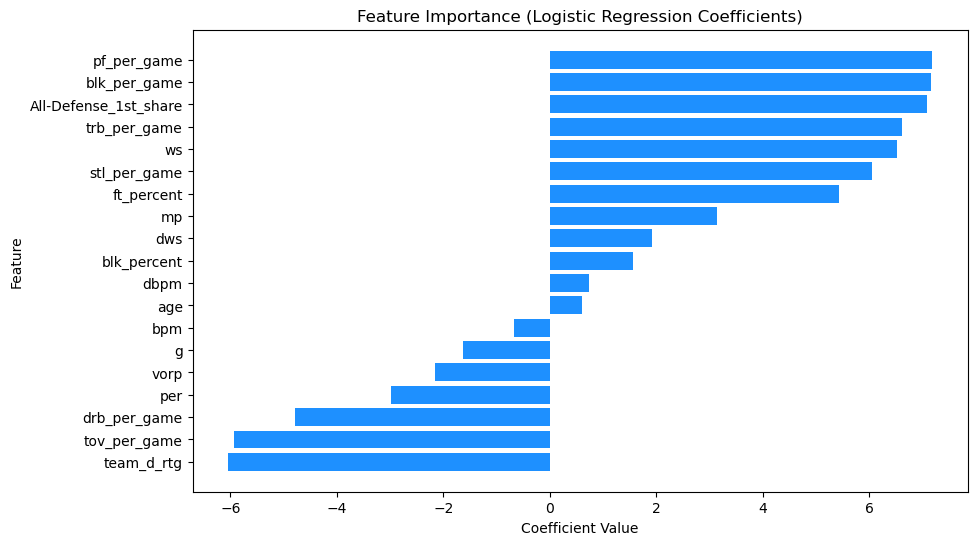

In [62]:
feature_importance = lr.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='dodgerblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.gca().invert_yaxis()
plt.show()

### Random-Forest Regression Model:

In [63]:
df = pd.read_csv("nba_dpoy_ml_data.csv", encoding='utf-8')
df.fillna(0, inplace=True)
print(list(df))

['seas_id', 'season', 'player_id', 'player', 'pos', 'age', 'experience', 'lg', 'tm', 'g', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game', 'award_aba mvp_share', 'award_aba roy_share', 'award_clutch_poy_share', 'award_dpoy_share', 'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 'award_smoy_share', 'All-Defense_1st_share', 'All-Defense_2nd_share', 'All-Defense_ORV_share', 'All-NBA_1st_share', 'All-NBA_2T_share', 'All-NBA_2nd_share', 'All-NBA_3T

In [64]:
data_columns = ['age', 'experience','g', 'mp', 'per', 'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent', 'stl_percent',
                'blk_percent', 'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'mp_per_game', 'fg_per_game', 'fga_per_game', 
                'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game', 'fta_per_game',
                'ft_percent', 'orb_per_game', 'drb_per_game', 'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game', 'tov_per_game', 'pf_per_game', 'pts_per_game',
                'award_aba mvp_share', 'award_aba roy_share', 'award_clutch_poy_share', 'award_mip_share', 'award_nba mvp_share', 'award_nba roy_share', 
                'award_smoy_share', 'All-Defense_1st_share', 'All-Defense_2nd_share', 'All-Defense_ORV_share', 'All-NBA_1st_share', 'All-NBA_2T_share', 'All-NBA_2nd_share', 
                'All-NBA_3T_share', 'All-NBA_3rd_share', 'All-NBA_ORV_share', 'All-Rookie_1st_share', 'All-Rookie_2nd_share', 'All-Rookie_ORV_share', 'All-Defense_1st',
                'All-Defense_2nd', 'All-Defense', 'All-NBA_1st', 'All-NBA_2nd', 'All-NBA', 'team_o_rtg', 'team_d_rtg', 'o_rtg', 'd_rtg']
                
df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [65]:
features = ['All-Defense_1st_share', 'blk_per_game', 'dws',
           'vorp', 'drb_per_game', 'ws','trb_per_game', 'blk_percent', 
           'per', 'mp', 'tov_per_game', 'age', 'team_d_rtg', 'stl_per_game', 'dbpm', 'g', 'ft_percent', 'bpm', 'pf_per_game',
           ]


target_variable = 'won_dpoy'

num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 19


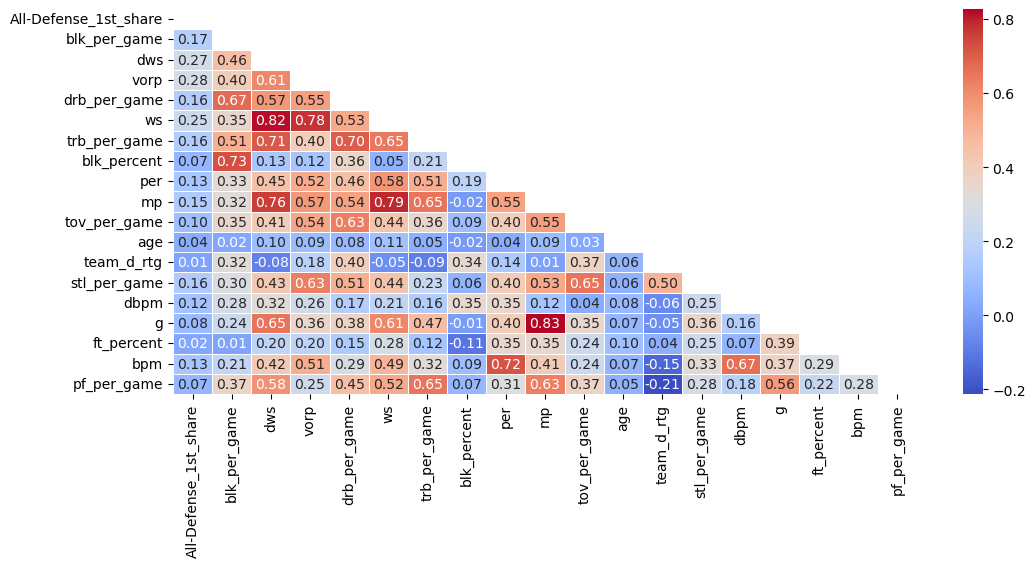

In [66]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

In [67]:
train = df[df["season"].between(1982, 2019)].copy()
test = df[df["season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rf = RandomForestRegressor(
    n_estimators=100,        
    max_depth=3,            
    min_samples_split=5,     
    min_samples_leaf=2,      
    random_state=5          
)
rf.fit(train[features], train["award_dpoy_share"])

predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["pred_ds"], index=test.index)
frame = pd.concat([test[["season", "player", "award_dpoy_share"]], predictions], axis=1)
frame.sort_values(["season", "pred_ds"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(5))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=10):
    true_relevance = df['award_dpoy_share'].values
    return ndcg_at_k(true_relevance, k=10)

ndcg_score_true = calculate_ndcg(frame, k=10)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["pred_ds"], index=test.index)
rf_reg_frame = pd.concat([test[["season", "player", "award_dpoy_share"]], predictions], axis=1)
rf_reg_frame.sort_values(["season", "pred_ds"], inplace=True, ascending=[False, False])

Results:

     season             player  award_dpoy_share   pred_ds
483    2024        Rudy Gobert             0.875  0.677611
555    2024  Victor Wembanyama             0.495  0.667256
36     2024        Bam Adebayo             0.184  0.398509
28     2024      Anthony Davis             0.168  0.272476
197    2024      Herbert Jones             0.028  0.172024
-----------------------------------------------------------------------------

NDCG Scores: 

True NDCG @:  0.9998541718127554
-----------------------------------------------------------------------------



In [68]:
actual = frame.sort_values("award_dpoy_share", ascending=False)
predicted = frame.sort_values("pred_ds", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="player").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

def find_ap(frame):
    actual = frame.sort_values("award_dpoy_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("pred_ds", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["player"] in actual["player"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP DPOY: ", ap)

Ranking Accuracy (Champion):

   season_x       player  award_dpoy_share_x  pred_ds_x  Rank  season_y  award_dpoy_share_y  pred_ds_y  Predicted Rank
0      2024  Rudy Gobert               0.875   0.677611     1      2024               0.875   0.677611               1

AP DPOY:  1.0


In [69]:
rf_reg_combined_predictions = pd.DataFrame(columns=["season", "player", "pred_ds", "award_dpoy_share"])

all_predictions = []
aps = []
ndcgs = []

backtest_seasons = [2024,2023,2022,2021,2020]

for season in backtest_seasons:
    train = df[df["season"].between(1982, 2019)].copy()
    test = df[df["season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['award_dpoy_share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["pred_ds"], index=test.index)
    frame = pd.concat([test[["player", "award_dpoy_share", "season"]], predictions_df], axis=1)

    # Append the predictions for the current season to the combined predictions DataFrame
    rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["award_dpoy_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("pred_ds", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["player", "pred_ds", "award_dpoy_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

# Save the combined predictions DataFrame to a CSV file
rf_reg_combined_predictions.to_csv("rf_curr_dpoy_preds.csv", index=False)

C:\Users\allen\AppData\Local\Temp\ipykernel_26400\1293306266.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, frame], ignore_index=True)


Champion AP for Season 2024: 1.0 | Reciprocal: 1.0 | NDCG: 1.0
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0 | NDCG: 0.97
Champion AP for Season 2022: 0.33 | Reciprocal: 3.0 | NDCG: 0.83
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0 | NDCG: 0.98
Champion AP for Season 2020: 0.33 | Reciprocal: 3.0 | NDCG: 0.82

Top 5 Predicted Teams for Season 2024:
                player   pred_ds  award_dpoy_share
483        Rudy Gobert  0.677611             0.875
555  Victor Wembanyama  0.667256             0.495
36         Bam Adebayo  0.398509             0.184
28       Anthony Davis  0.272476             0.168
197      Herbert Jones  0.172024             0.028
434       Nikola Jokić  0.002947             0.000
29     Anthony Edwards  0.002576             0.000
149   Domantas Sabonis  0.001027             0.002
258      Jarrett Allen  0.001027             0.002
321       Jusuf Nurkić  0.001027             0.000

Top 5 Predicted Teams for Season 2023:
                player   pred_ds  awar

### Random-Forest Regression on Current DPOY's:
- The model was 3/5 in terms predicting the last 5 season dpoys.
- It labeled Giannis Antet. as ranked 3rd in 2020.
- It labeled Marcus Smart as ranked 3rd in 2022.
- Overall it outperformed the logistic classifier.

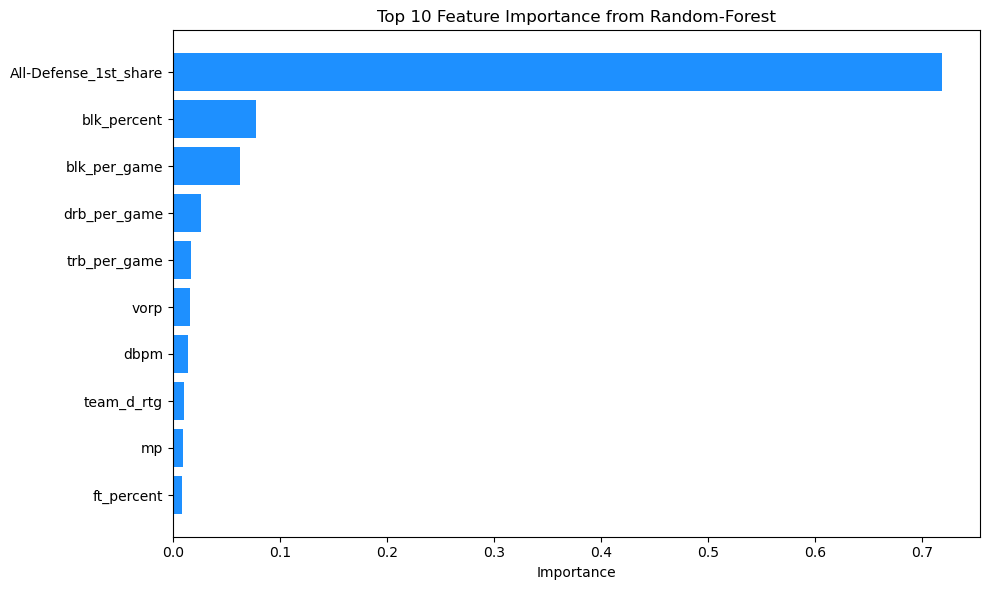

In [70]:
rf_importance = rf.feature_importances_
sorted_idx = np.argsort(rf_importance)[::-1]
top_features = [features[i] for i in sorted_idx[:10]]
importance_values = rf_importance[sorted_idx[:10]]

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar chart
ax.barh(top_features, importance_values, color='dodgerblue')
ax.set_title('Top 10 Feature Importance from Random-Forest')
ax.set_xlabel('Importance') 
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Finding the Missing DPOY's (1982-1947):

In [71]:
rf_reg_combined_predictions = pd.DataFrame(columns=["season", "player", "pred_ds", "award_dpoy_share", 
                                                    'top_pred'])

backtest_seasons = [1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971,
                    1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959,
                    1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948, 1947]

for season in backtest_seasons:
    train = df[df["season"].between(1982, 2019)].copy()
    test = df[df["season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train["award_dpoy_share"])

    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["pred_ds"], index=test.index)
    frame = pd.concat([test[["season", "player", "award_dpoy_share"]], predictions_df], axis=1)
    frame.sort_values(["season", "pred_ds"], inplace=True, ascending=[False, False])

    frame['top_pred'] = 0
    if not frame.empty:
        frame.loc[frame['pred_ds'].idxmax(), 'top_pred'] = 1

    top_3_predictions = frame.head(5)
    rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, top_3_predictions], ignore_index=True)

rf_reg_combined_predictions.to_csv("top_5_pred_1947_1982.csv", index=False)

C:\Users\allen\AppData\Local\Temp\ipykernel_26400\3666919976.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, top_3_predictions], ignore_index=True)


### Analyze Findings:
- Power-BI and Python is used to evaluate the findings.
- Identify top predictions for each season.
- Return a true probability column (out of 100%).

In [73]:
season_sum = rf_reg_combined_predictions.groupby('season')['pred_ds'].transform('sum')

rf_reg_combined_predictions['dpoy_100'] = rf_reg_combined_predictions['pred_ds'] / season_sum

df_sorted = rf_reg_combined_predictions.sort_values(by=['season', 'dpoy_100'], ascending=[True, False]).reset_index(drop=True)

transformed_data = []
for season, group in df_sorted.groupby('season'):
    players = group['player'].tolist()
    dpoy_100 = group['dpoy_100'].tolist()
    pred_ds = group['pred_ds'].tolist()
    
    row = [season] + sum([[players[i], dpoy_100[i]] for i in range(5)], []) + pred_ds[:5]
    transformed_data.append(row)

columns = ['season', '1st_place_player', 'dpoy_100', '2nd_place_player', 'dpoy_100', '3rd_place_player', 'dpoy_100', '4th_place_player', 'dpoy_100', '5th_place_player', 'dpoy_100', 'pred_ds', 'pred_ds', 'pred_ds','pred_ds', 'pred_ds']

df_transformed = pd.DataFrame(transformed_data, columns=columns)

df_transformed.to_csv("charted_top_5_pred_1947_1982.csv", index=False)